In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, ConstantKernel as C


In [2]:

# 例: あなたのnpz（listのまま保存されている前提）
d = np.load("dataset_irregular.npz", allow_pickle=True)
train_list = d["train_list"].tolist()

# 1サンプル = [cycle_id, deg, s1, label]
def extract_cycle(sample_list, cycle_id):
    arr = np.asarray(sample_list, dtype=object)
    rows = arr[arr[:,0].astype(int) == int(cycle_id)]
    deg = rows[:,1].astype(float)
    y   = rows[:,2].astype(float)
    lab = int(rows[0,3]) if len(rows) else -1
    idx = np.argsort(deg)  # 不等間隔なので昇順に
    return deg[idx], y[idx], lab

first_cycle_id = int(train_list[0][0])   # trainの最初のサイクル
deg, y, lab = extract_cycle(train_list, first_cycle_id)

X = deg.reshape(-1, 1)


In [3]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# X: (N,1) 角度[deg]、y: (N,) センサ
# X = deg.reshape(-1, 1)
# y = s1.astype(float)

# 初期値は「推定の出発点」なので雑でOK。fitで自動最適化される。
y_var = float(np.var(y)) + 1e-12

kernel = C(y_var, (1e-6, 1e6)) * RBF(
    length_scale=30.0,               # 出発点: 30deg くらい
    length_scale_bounds=(0.5, 300.0) # 自動推定で動ける範囲を広めに
) + WhiteKernel(
    noise_level=0.1 * y_var,         # 出発点: 分散の1割くらい
    noise_level_bounds=(1e-8, 1e2)   # 十分広めに
)

gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10,  # 自動推定の安定性が上がる（重くはなる）
    random_state=0
)

gpr.fit(X, y)

deg_grid = np.linspace(0, 360, 512).reshape(-1, 1)
mu, std = gpr.predict(deg_grid, return_std=True)

print("learned kernel:", gpr.kernel_)

learned kernel: 0.921**2 * RBF(length_scale=33.1) + WhiteKernel(noise_level=0.012)


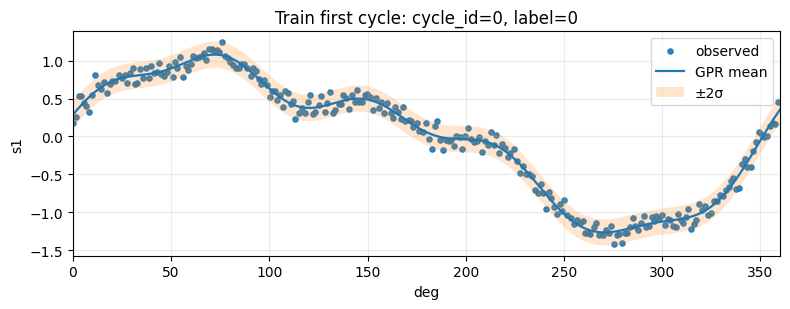

In [4]:

plt.figure(figsize=(8, 3.2))
plt.scatter(deg, y, s=14, alpha=0.9, label="observed")
plt.plot(deg_grid.ravel(), mu, linewidth=1.6, label="GPR mean")
plt.fill_between(deg_grid.ravel(), mu-2*std, mu+2*std, alpha=0.2, label="±2σ")
plt.xlim(0, 360)
plt.xlabel("deg")
plt.ylabel("s1")
plt.title(f"Train first cycle: cycle_id={first_cycle_id}, label={lab}")
plt.grid(True, alpha=0.25)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# GRP → wavelet CWT → AE

In [5]:
import numpy as np
import pywt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, ConstantKernel

# ============================================================
# 0) 設定（ここだけ調整）
# ============================================================
NPZ_PATH = "dataset_irregular.npz"

L_GRID   = 256                  # 等間隔グリッド（CWT横幅）
N_SCALES = 64                   # CWT縦幅（MaxPool2回なので4の倍数推奨）
# 位相情報（横ずれ）を残すため複素ウェーブレットを使う
WAVELET  = "cmor1.5-1.0"        # 複素Morlet（PyWavelets表記）

TRAIN_RATIO = 0.70              # 正常のうちAE学習用
VAL_RATIO   = 0.10              # 正常のうち学習の監視用（任意）
CAL_RATIO   = 0.20              # 正常のうち閾値決定用（AE学習に使わない）
THR_Q       = 0.995             # calib正常スコアの分位点で閾値

EPOCHS = 50
BATCH  = 64
LR     = 1e-3
SEED   = 0

np.random.seed(SEED)
tf.random.set_seed(SEED)

assert (L_GRID % 4 == 0) and (N_SCALES % 4 == 0), "L_GRID と N_SCALES は 4 の倍数推奨（MaxPool2回のため）"
assert abs((TRAIN_RATIO + VAL_RATIO + CAL_RATIO) - 1.0) < 1e-9, "TRAIN/VAL/CAL の比率の合計を 1.0 にしてください"

# ============================================================
# 1) 読み込み（1サンプル=[cycle_id, deg, s1, label]）
# ============================================================
d = np.load(NPZ_PATH, allow_pickle=True)
train_list = d["train_list"].tolist()
test_list  = d["test_list"].tolist()

def group_by_cycle(sample_list):
    arr = np.asarray(sample_list, dtype=object)
    cid = arr[:,0].astype(int)
    deg = arr[:,1].astype(float)
    y   = arr[:,2].astype(float)
    lab = arr[:,3].astype(int)

    order = np.lexsort((deg, cid))   # cycle→deg
    cid, deg, y, lab = cid[order], deg[order], y[order], lab[order]

    cycles = {}
    start = 0
    while start < len(cid):
        c = int(cid[start])
        end = start
        while end < len(cid) and int(cid[end]) == c:
            end += 1
        cycles[c] = (deg[start:end], y[start:end], int(lab[start]))
        start = end
    return cycles

train_cycles = group_by_cycle(train_list)
test_cycles  = group_by_cycle(test_list)

def count_labels_from_cycles(cycles_dict):
    labs = np.array([lab for (_,_,lab) in cycles_dict.values()], dtype=int)
    u, c = np.unique(labs, return_counts=True)
    return {int(k): int(v) for k, v in zip(u, c)}

print("\n[cycle counts]")
print("train cycles total:", len(train_cycles))
print("test  cycles total:", len(test_cycles))
print("train label counts:", count_labels_from_cycles(train_cycles))
print("test  label counts:", count_labels_from_cycles(test_cycles))



[cycle counts]
train cycles total: 700
test  cycles total: 1020
train label counts: {0: 700}
test  label counts: {0: 720, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


In [6]:

# ============================================================
# 2) グリッドとCWTスケール
# ============================================================
deg_grid = np.linspace(0, 360, L_GRID, endpoint=False).astype(float)
deg_step = float(deg_grid[1] - deg_grid[0])
scales   = np.arange(1, N_SCALES + 1)

# ============================================================
# 3) GPR（重要: normalize_y=False で上下シフトを消さない）
#    まず正常1サイクルでカーネルのパラメータを自動推定 → 固定
# ============================================================
def fit_kernel_on_one_cycle(deg, y):
    X = deg.reshape(-1, 1)
    y = y.astype(float)

    # 定数カーネルを「別に足す」ことで、上下シフト（オフセット）を表現しやすくする
    k_offset = ConstantKernel(1.0, (1e-3, 1e3))
    k_per    = ConstantKernel(1.0, (1e-3, 1e3)) * ExpSineSquared(
        length_scale=30.0, periodicity=360.0,
        length_scale_bounds=(0.5, 300.0),
        periodicity_bounds="fixed"
    )
    k_noise  = WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-6, 1.0))
    kernel0  = k_offset + k_per + k_noise

    gpr = GaussianProcessRegressor(
        kernel=kernel0,
        normalize_y=False,          # ★上下シフトを消さない
        n_restarts_optimizer=2,
        random_state=SEED
    )
    gpr.fit(X, y)
    return gpr.kernel_

def gpr_mu_on_grid(deg, y, kernel_frozen):
    X = deg.reshape(-1, 1)
    gpr = GaussianProcessRegressor(
        kernel=kernel_frozen,
        normalize_y=False,          # ★上下シフトを消さない
        optimizer=None              # 各サイクルでハイパラ最適化しない（高速化）
    )
    gpr.fit(X, y.astype(float))
    mu = gpr.predict(deg_grid.reshape(-1, 1)).astype(np.float32)
    return mu

normal_ids = [cid for cid, (_, _, lab) in train_cycles.items() if lab == 0]
if len(normal_ids) == 0:
    raise ValueError("trainに label==0（正常）がありません。")

deg0, y0, _ = train_cycles[normal_ids[0]]
kernel_frozen = fit_kernel_on_one_cycle(deg0, y0)
print("\nlearned kernel:", kernel_frozen)



learned kernel: 0.0316**2 + 0.706**2 * ExpSineSquared(length_scale=0.628, periodicity=360) + WhiteKernel(noise_level=0.00706)


d:\tsenz\testPython\mystudy_alibi\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [7]:

# ============================================================
# 4) 特徴：GPR mu → CWT係数（実部/虚部） + DC（平均）チャネル
#    横ずれ: 複素CWTの位相が効く（実部/虚部）
#    上下シフト: DCチャネルが効く（CWT自体は定数に鈍感になりやすい）
# ============================================================
def mu_to_cwt_channels(mu):
    # 周期端の影響を減らす（3回つないで中央のみ）
    mu3 = np.r_[mu, mu, mu]
    coef, _ = pywt.cwt(mu3, scales, WAVELET, sampling_period=deg_step)
    coef = coef[:, L_GRID:2*L_GRID]  # 中央

    re = np.real(coef).astype(np.float32)
    im = np.imag(coef).astype(np.float32)

    # 上下シフト用: muの平均（DC）を画像にブロードキャスト
    dc_val = float(np.mean(mu))
    dc = np.full_like(re, dc_val, dtype=np.float32)

    # (S, T, 3)
    return np.stack([re, im, dc], axis=-1)

# ============================================================
# 5) サイクル集合 → Tensor (N, S, T, C)
# ============================================================
def build_tensor(cycles_dict, kernel_frozen, only_label0=False):
    X_list, y_list, cid_list = [], [], []
    for cid, (deg, y, lab) in cycles_dict.items():
        if only_label0 and lab != 0:
            continue
        mu = gpr_mu_on_grid(deg, y, kernel_frozen)  # (T,)
        Z  = mu_to_cwt_channels(mu)                 # (S,T,3)
        X_list.append(Z)
        y_list.append(int(lab))
        cid_list.append(int(cid))

    X = np.stack(X_list, axis=0).astype(np.float32)  # (N,S,T,3)
    y = np.array(y_list, dtype=int)
    cid = np.array(cid_list, dtype=int)
    return X, y, cid

Xtr0, ytr0, cidtr0 = build_tensor(train_cycles, kernel_frozen, only_label0=True)   # 正常のみ
Xte,  yte,  cidte  = build_tensor(test_cycles,  kernel_frozen, only_label0=False)  # 全ラベル

print("\n[tensor shapes]")
print("Xtr0(normal-only):", Xtr0.shape, " (N,S,T,C)")
print("Xte (all labels): ", Xte.shape)



[tensor shapes]
Xtr0(normal-only): (700, 64, 256, 3)  (N,S,T,C)
Xte (all labels):  (1020, 64, 256, 3)


In [8]:

# ============================================================
# 6) 正常を train / val / calib に分割（calibは閾値専用）
# ============================================================
n0 = Xtr0.shape[0]
idx = np.arange(n0)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)

n_train = int(round(TRAIN_RATIO * n0))
n_val   = int(round(VAL_RATIO   * n0))
n_cal   = n0 - n_train - n_val

if n_train < 1 or n_cal < 1:
    raise ValueError("正常サイクル数が少なすぎます。割合かデータ数を見直してください。")

tr_idx  = idx[:n_train]
val_idx = idx[n_train:n_train+n_val] if n_val > 0 else np.array([], int)
cal_idx = idx[n_train+n_val:]

X_train = Xtr0[tr_idx]
X_val   = Xtr0[val_idx] if n_val > 0 else None
X_calib = Xtr0[cal_idx]

print("\n[normal split counts]")
print("normal total:", n0)
print("train:", X_train.shape[0], "val:", (0 if X_val is None else X_val.shape[0]), "calib(threshold):", X_calib.shape[0])

# 正規化は train 正常のみで決める（情報漏れ防止）
m = float(X_train.mean())
s = float(X_train.std() + 1e-8)

X_train = (X_train - m) / s
X_calib = (X_calib - m) / s
Xte_n   = (Xte    - m) / s
if X_val is not None:
    X_val = (X_val - m) / s



[normal split counts]
normal total: 700
train: 490 val: 70 calib(threshold): 140


In [9]:

# ============================================================
# 7) TensorFlow Conv2D AutoEncoder（入力C=3 → 出力C=3）
# ============================================================
def build_conv_ae(input_shape):
    inp = tf.keras.Input(shape=input_shape)  # (S,T,3)

    x = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu")(inp)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    out = tf.keras.layers.Conv2D(3, 3, padding="same")(x)  # ★3チャネル復元
    model = tf.keras.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="mse")
    return model

ae = build_conv_ae(X_train.shape[1:])
ae.summary()

callbacks = []
if X_val is not None and X_val.shape[0] >= 1:
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True))

ae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val) if X_val is not None else None,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=callbacks,
    verbose=1
)

# ============================================================
# 8) 復元誤差 → calib正常で閾値 → テスト判定
# ============================================================
def recon_error(model, X):
    R = model.predict(X, batch_size=BATCH, verbose=0)
    err = np.mean((R - X)**2, axis=(1,2,3))
    return err

score_cal = recon_error(ae, X_calib)
thr = float(np.quantile(score_cal, THR_Q))
print("\nthreshold(from calib normal):", thr)

score_te = recon_error(ae, Xte_n)
pred_te = (score_te > thr).astype(int)

# 簡易評価（正常=0 vs それ以外）
y_te_bin = (yte != 0).astype(int)
acc = float(np.mean(pred_te == y_te_bin))
print("test acc (normal vs others):", acc)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 256, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 128, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 128, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 128, 32)    │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 256, 16)    │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 256, 3)     │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,395 (75.76 KB)

 Trainable params: 19,395 (75.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 0.9638 - val_loss: 0.8968
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.7799 - val_loss: 0.6036
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.4761 - val_loss: 0.3371
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.2491 - val_loss: 0.1316
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0906 - val_loss: 0.0559
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0468 - val_loss: 0.0377
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0305 - val_loss: 0.0248
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.0221 - val_loss: 0.0190
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0172 - val_loss: 0.0155
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.0144 - val_loss: 0.0131
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0110 - val_lo

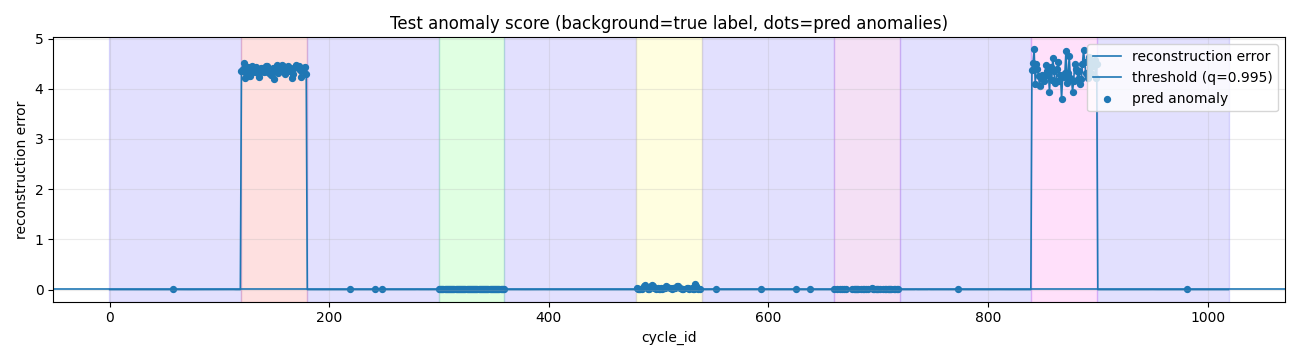

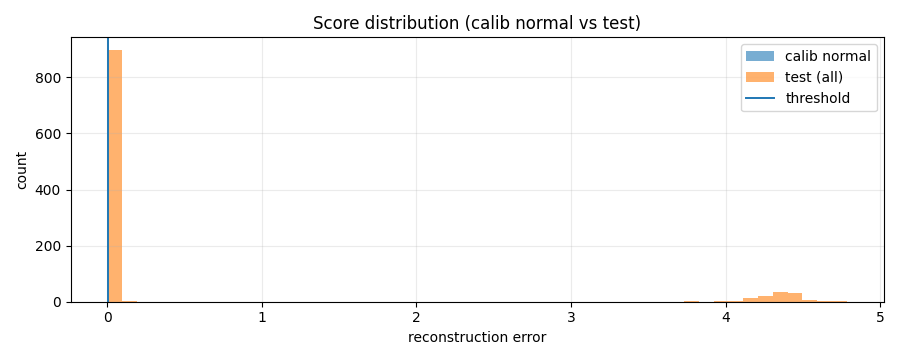

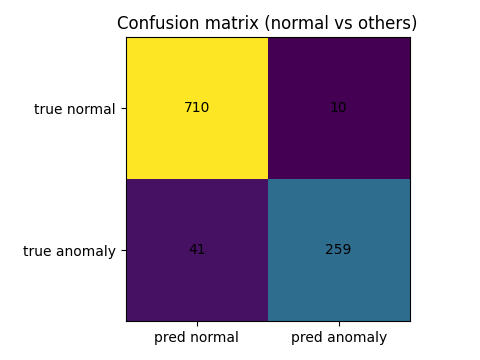


metrics: {'acc': 0.95, 'tpr(recall)': 0.8633333333333333, 'fpr': 0.013888888888888888, 'tp': 259, 'tn': 710, 'fp': 10, 'fn': 41}


In [10]:
%matplotlib widget
# ============================================================
# 9) 可視化（スコア時系列 / 分布 / 混同行列）
# ============================================================
label_name  = {0:"正常",1:"上下",2:"横ずれ",3:"周波数",4:"スパイク",5:"mix"}
label_color = {0:"#1100fd",1:"#f80303",2:"#00ff15",3:"#fffb00",4:"#ab00b1",5:"#ff00dd"}

order = np.argsort(cidte)
cid_s   = cidte[order]
y_s     = yte[order]
score_s = score_te[order]
pred_s  = pred_te[order]

# 図1) テスト全体：スコア時系列 + 閾値 + 背景(真ラベル) + 予測異常マーク
plt.figure(figsize=(13, 3.6))
plt.plot(cid_s, score_s, linewidth=1.2, label="reconstruction error")
plt.axhline(thr, linewidth=1.2, label=f"threshold (q={THR_Q})")

start = 0
while start < len(cid_s):
    lab = int(y_s[start])
    end = start
    while end < len(cid_s) and int(y_s[end]) == lab:
        end += 1
    x0 = cid_s[start] - 0.5
    x1 = cid_s[end-1] + 0.5
    plt.axvspan(x0, x1, alpha=0.12, color=label_color.get(lab, "#ffffff"))
    start = end

idx_anom = np.where(pred_s == 1)[0]
plt.scatter(cid_s[idx_anom], score_s[idx_anom], s=18, marker="o", label="pred anomaly")

plt.xlabel("cycle_id")
plt.ylabel("reconstruction error")
plt.title("Test anomaly score (background=true label, dots=pred anomalies)")
plt.grid(True, alpha=0.25)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 図2) 分布：calib正常 vs テスト
plt.figure(figsize=(9.0, 3.6))
plt.hist(score_cal, bins=50, alpha=0.6, label="calib normal")
plt.hist(score_te,  bins=50, alpha=0.6, label="test (all)")
plt.axvline(thr, linewidth=1.4, label="threshold")
plt.xlabel("reconstruction error")
plt.ylabel("count")
plt.title("Score distribution (calib normal vs test)")
plt.grid(True, alpha=0.25)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 図3) 混同行列（正常 vs それ以外）
tp = int(np.sum((pred_te == 1) & (y_te_bin == 1)))
tn = int(np.sum((pred_te == 0) & (y_te_bin == 0)))
fp = int(np.sum((pred_te == 1) & (y_te_bin == 0)))
fn = int(np.sum((pred_te == 0) & (y_te_bin == 1)))

cm = np.array([[tn, fp],
               [fn, tp]], dtype=int)

plt.figure(figsize=(4.8, 3.6))
plt.imshow(cm, interpolation="nearest")
plt.xticks([0,1], ["pred normal", "pred anomaly"])
plt.yticks([0,1], ["true normal", "true anomaly"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.title("Confusion matrix (normal vs others)")
plt.tight_layout()
plt.show()

acc2 = (tp + tn) / max(1, tp + tn + fp + fn)
tpr  = tp / max(1, tp + fn)
fpr  = fp / max(1, fp + tn)
print("\nmetrics:", {"acc": acc2, "tpr(recall)": tpr, "fpr": fpr, "tp": tp, "tn": tn, "fp": fp, "fn": fn})